In [2]:
from typing import List, Dict, Optional
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import sys 
sys.path.append(".")
sys.path.append("..")

from pipeline_attend_and_excite import AttendAndExcitePipeline
from config import RunConfig
from run import run_on_prompt, get_indices_to_alter
from utils import vis_utils
from utils.ptp_utils import AttentionStore
from flair.models import SequenceTagger
from flair.data import Sentence

tagger = SequenceTagger.load("pos")
%load_ext autoreload 
%autoreload 2

2023-06-17 08:46:49,219 SequenceTagger predicts: Dictionary with 53 tags: <unk>, O, UH, ,, VBD, PRP, VB, PRP$, NN, RB, ., DT, JJ, VBP, VBG, IN, CD, NNS, NNP, WRB, VBZ, WDT, CC, TO, MD, VBN, WP, :, RP, EX, JJR, FW, XX, HYPH, POS, RBR, JJS, PDT, NNPS, RBS, AFX, WP$, -LRB-, -RRB-, ``, '', LS, $, SYM, ADD


# Load Model Weights (may take a few minutes)

In [3]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
tokenizer = stable.tokenizer

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


# Pipeline Wrapper

In [4]:
# configurable parameters (see RunConfig for all parameters)
# scale factor - intensity of shift by gradient
# thresholds - a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    generator: torch.Generator,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {0:0.05, 10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False,
                    sd_2_1: bool = False):
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter,
                       sd_2_1=sd_2_1
                       )
    image = run_on_prompt(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          seed=generator,
                          config=config)
    if display_output:
        display(image)
    return image

# Run Inference on a Set of Seeds and Generate an Image Grid

In [5]:
def extract_nouns(prompt: str):
    prompt = Sentence(prompt)
    tagger.predict(prompt)
    noun_idx = [idx + 1 for idx, token in enumerate(prompt) if token.tag == "NN"]
    return noun_idx

def generate_images_for_method(prompt: str,
                               seeds: List[int],
                               indices_to_alter: Optional[List[int]] = None,
                               is_attend_and_excite: bool = True,
                               sd_2_1: bool = False,
                               use_pos_tagger: bool = False):
    if use_pos_tagger:
        token_indices = extract_nouns(prompt) 
        print(f"Using POS tagger to extract nouns: {prompt} -> {token_indices}")
    else:    
        token_indices = get_indices_to_alter(stable, prompt) if indices_to_alter is None else indices_to_alter
    
    images = []
    for seed in seeds:
        g = torch.Generator('cuda').manual_seed(seed)
        prompts = [prompt]
        controller = AttentionStore()
        run_standard_sd = False if is_attend_and_excite else True
        image = run_and_display(prompts=prompts,
                                controller=controller,
                                indices_to_alter=token_indices,
                                generator=g,
                                run_standard_sd=run_standard_sd,
                                sd_2_1=sd_2_1)
        images.append(image.resize((256, 256)))
    grid = vis_utils.get_image_grid(images)
    display(grid)

# Stable Diffusion vs. Attend-and-Excite

## Stable Diffusion

In [8]:
generate_images_for_method(
    prompt="a cat and a frog",
    seeds=[6141, 9031, 969, 1910],
    is_attend_and_excite=True,
    use_pos_tagger=True
)

Using POS tagger to extract nouns: a cat and a frog -> [2, 5]


  0%|          | 0/50 [00:00<?, ?it/s]

## Attend-and-Excite

In [16]:
generate_images_for_method(
    prompt="a cat and a frog",
    seeds=[6141, 9031, 969, 1910],
    is_attend_and_excite=True
)

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'frog'}


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ ❱ 1 generate_images_for_method(                                                                  │
│   2 │   prompt="a cat and a frog",                                                               │
│   3 │   seeds=[6141, 9031, 969, 1910],                                                           │
│   4 │   is_attend_and_excite=True                                                                │
│                                                                                                  │
│ in generate_images_for_method                                                                    │
│                                                                                                  │
│   14 │   │   token_indices = extract_nouns(prompt)                                               │
│   15 │   │   print(f"Using POS tagger to extract nouns: {prompt} -> {token_indices}")            │
│   16 │   else:                                                                                   │
│ ❱ 17 │   │   token_indices = get_indices_to_alter(stable, prompt) if indices_to_alter is None    │
│   18 │                                                                                           │
│   19 │   images = []                                                                             │
│   20 │   for seed in seeds:                                                                      │
│                                                                                                  │
│ /nobackup/wenxuan/Stable-Diffusion-Compositions-Analysis/Attend-and-Excite/notebooks/../run.py:3 │
│ 5 in get_indices_to_alter                                                                        │
│                                                                                                  │
│   32 │   pprint.pprint(token_idx_to_word)                                                        │
│   33 │   token_indices = input("Please enter the a comma-separated list indices of the tokens    │
│   34 │   │   │   │   │   │     "alter (e.g., 2,5): ")                                            │
│ ❱ 35 │   token_indices = [int(i) for i in token_indices.split(",")]                              │
│   36 │   print(f"Altering tokens: {[token_idx_to_word[i] for i in token_indices]}")              │
│   37 │   return token_indices                                                                    │
│   38                                                                                             │
│                                                                                                  │
│ /nobackup/wenxuan/Stable-Diffusion-Compositions-Analysis/Attend-and-Excite/notebooks/../run.py:3 │
│ 5 in <listcomp>                                                                                  │
│                                                                                                  │
│   32 │   pprint.pprint(token_idx_to_word)                                                        │
│   33 │   token_indices = input("Please enter the a comma-separated list indices of the tokens    │
│   34 │   │   │   │   │   │     "alter (e.g., 2,5): ")                                            │
│ ❱ 35 │   token_indices = [int(i) for i in token_indices.split(",")]                              │
│   36 │   print(f"Altering tokens: {[token_idx_to_word[i] for i in token_indices]}")              │
│   37 │   return token_indices                                                                    │
│   38                                                                                             │
╰────────────────────────────────────────────────────────────

## Stable Diffusion

In [7]:
generate_images_for_method(
    prompt="a mouse and a red car",
    seeds=[7803, 2098, 15792, 2354],
    is_attend_and_excite=False
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ ❱ 1 generate_images_for_method(                                                                  │
│   2 │   prompt="a mouse and a red car",                                                          │
│   3 │   seeds=[7803, 2098, 15792, 2354],                                                         │
│   4 │   is_attend_and_excite=False                                                               │
│                                                                                                  │
│ in generate_images_for_method                                                                    │
│                                                                                                  │
│    3 │   │   │   │   │   │   │      indices_to_alter: Optional[List[int]] = None,                │
│    4 │   │   │   │   │   │   │      is_attend_and_excite: bool = True,                           │
│    5 │   │   │   │   │   │   │      sd_2_1: bool = False):                                       │
│ ❱  6 │   token_indices = get_indices_to_alter(stable, prompt) if indices_to_alter is None els    │
│    7 │   images = []                                                                             │
│    8 │   for seed in seeds:                                                                      │
│    9 │   │   g = torch.Generator('cuda').manual_seed(seed)                                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'stable' is not defined

## Attend-and-Excite

In [8]:
generate_images_for_method(
    prompt="a mouse and a red car",
    seeds=[7803, 2098, 15792, 2354],
    is_attend_and_excite=True
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ ❱ 1 generate_images_for_method(                                                                  │
│   2 │   prompt="a mouse and a red car",                                                          │
│   3 │   seeds=[7803, 2098, 15792, 2354],                                                         │
│   4 │   is_attend_and_excite=True                                                                │
│                                                                                                  │
│ in generate_images_for_method                                                                    │
│                                                                                                  │
│    3 │   │   │   │   │   │   │      indices_to_alter: Optional[List[int]] = None,                │
│    4 │   │   │   │   │   │   │      is_attend_and_excite: bool = True,                           │
│    5 │   │   │   │   │   │   │      sd_2_1: bool = False):                                       │
│ ❱  6 │   token_indices = get_indices_to_alter(stable, prompt) if indices_to_alter is None els    │
│    7 │   images = []                                                                             │
│    8 │   for seed in seeds:                                                                      │
│    9 │   │   g = torch.Generator('cuda').manual_seed(seed)                                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'stable' is not defined

# Stable Diffusion 2.1

In [9]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base").to(device)
tokenizer = stable.tokenizer

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'dog'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2,5
Altering tokens: ['cat', 'dog']


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

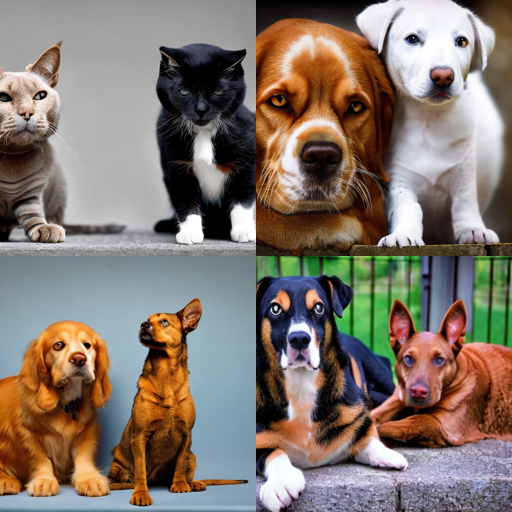

In [ ]:
generate_images_for_method(
    prompt="a cat and a dog",
    seeds=[39, 63, 68, 62],
    is_attend_and_excite=False,
    sd_2_1=True
)

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'dog'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2,5
Altering tokens: ['cat', 'dog']


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.3958
Iteration 1 | Loss: 0.3280
Iteration 2 | Loss: 0.3427
Iteration 3 | Loss: 0.1661
Iteration 4 | Loss: 0.1190
Iteration 5 | Loss: 0.0945
Iteration 6 | Loss: 0.0955
Iteration 7 | Loss: 0.0894
Iteration 8 | Loss: 0.0798
Iteration 9 | Loss: 0.0650
Iteration 10 | Loss: 0.0674
Iteration 11 | Loss: 0.0554
Iteration 12 | Loss: 0.0626
Iteration 13 | Loss: 0.0520
Iteration 14 | Loss: 0.0562
Iteration 15 | Loss: 0.0540
Iteration 16 | Loss: 0.0580
Iteration 17 | Loss: 0.0555
Iteration 18 | Loss: 0.0591
Iteration 19 | Loss: 0.0577
Iteration 20 | Loss: 0.0603
Iteration 21 | Loss: 0.0610
Iteration 22 | Loss: 0.0623
Iteration 23 | Loss: 0.0640
Iteration 24 | Loss: 0.0669


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.4346
Iteration 1 | Loss: 0.4535
Iteration 2 | Loss: 0.4684
Iteration 3 | Loss: 0.3153
Iteration 4 | Loss: 0.1984
Iteration 5 | Loss: 0.1573
Iteration 6 | Loss: 0.1456
Iteration 7 | Loss: 0.1201
Iteration 8 | Loss: 0.1350
Iteration 9 | Loss: 0.1008
Iteration 10 | Loss: 0.1329
Iteration 11 | Loss: 0.0906
Iteration 12 | Loss: 0.1296
Iteration 13 | Loss: 0.0818
Iteration 14 | Loss: 0.1011
Iteration 15 | Loss: 0.0720
Iteration 16 | Loss: 0.0843
Iteration 17 | Loss: 0.0660
Iteration 18 | Loss: 0.0814
Iteration 19 | Loss: 0.0623
Iteration 20 | Loss: 0.0844
Iteration 21 | Loss: 0.0625
Iteration 22 | Loss: 0.0759
Iteration 23 | Loss: 0.0679
Iteration 24 | Loss: 0.0725


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.4947
Iteration 1 | Loss: 0.5245
Iteration 2 | Loss: 0.5280
Iteration 3 | Loss: 0.2731
Iteration 4 | Loss: 0.1977
Iteration 5 | Loss: 0.1962
Iteration 6 | Loss: 0.1827
Iteration 7 | Loss: 0.1865
Iteration 8 | Loss: 0.1470
Iteration 9 | Loss: 0.1522
Iteration 10 | Loss: 0.1503
Iteration 11 | Loss: 0.1438
Iteration 12 | Loss: 0.1330
Iteration 13 | Loss: 0.1239
Iteration 14 | Loss: 0.1183
Iteration 15 | Loss: 0.1111
Iteration 16 | Loss: 0.1059
Iteration 17 | Loss: 0.1010
Iteration 18 | Loss: 0.0981
Iteration 19 | Loss: 0.0967
Iteration 20 | Loss: 0.0967
Iteration 21 | Loss: 0.0975
Iteration 22 | Loss: 0.0990
Iteration 23 | Loss: 0.1005
Iteration 24 | Loss: 0.1025


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.3568
Iteration 1 | Loss: 0.3141
Iteration 2 | Loss: 0.3440
Iteration 3 | Loss: 0.1994
Iteration 4 | Loss: 0.1034
Iteration 5 | Loss: 0.0802
Iteration 6 | Loss: 0.0877
Iteration 7 | Loss: 0.0764
Iteration 8 | Loss: 0.0889
Iteration 9 | Loss: 0.0600
Iteration 10 | Loss: 0.0542
Iteration 11 | Loss: 0.0406
Iteration 12 | Loss: 0.0441
Iteration 13 | Loss: 0.0340
Iteration 14 | Loss: 0.0366
Iteration 15 | Loss: 0.0274
Iteration 16 | Loss: 0.0309
Iteration 17 | Loss: 0.0273
Iteration 18 | Loss: 0.0306
Iteration 19 | Loss: 0.0290
Iteration 20 | Loss: 0.0332
Iteration 21 | Loss: 0.0325
Iteration 22 | Loss: 0.0365
Iteration 23 | Loss: 0.0381
Iteration 24 | Loss: 0.0385


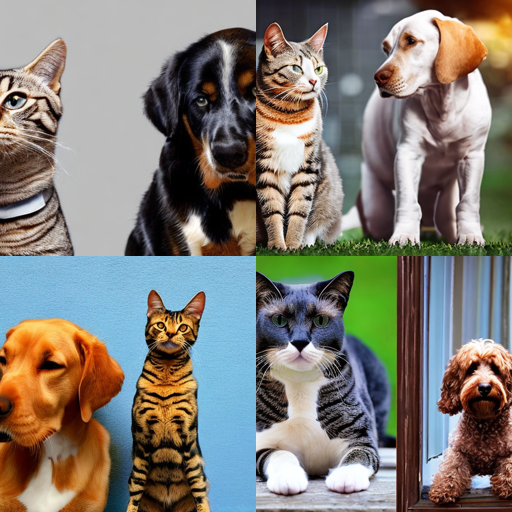

In [ ]:
generate_images_for_method(
    prompt="a cat and a dog",
    seeds=[39, 63, 68, 62],
    is_attend_and_excite=True,
    sd_2_1=True
)